Lidan Avisar

# Overview
### Due Jan 25th

### GAN, chroma (MIDI) and pix2pix

Instructions:

* This notebook is an interactive assignment; please read and follow the instructions in each cell.

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook and printout as a PDF.


In this notebook we explore a style transfer application that tries to change the musical texture of a piece while maintaining the harmonic structure. In order to do so we train a pix2pix type of model that learns the relations between chroma and the musical texture (distribution of notes). For this purpose we extract chroma from MIDI data and learn a generator that complements the notes from a given texture. You can think about this as something similar to pix2pix that learns completion of image textures from a sketch. In the image GAN the contours for training are generated using an edge detection on a complete image. You can read more about the history of Midi formats at https://cecm.indiana.edu/361/midi.html#:~:text=MIDI%20is%20an%20acronym%20that,each%20other%2C%20using%20MIDI%20messages.

# 1. Imports and Loading Data
Before running, please download the files from https://drive.google.com/drive/folders/1B3WpC9hRH4W6yzh7gahFAZodw1lP4aaM?usp=share_link make sure to upload the following to your python directory
- reverse_pianoroll.py
- convert.py
- Classical_Music_Midi.zip and unzip it

In [44]:
!unzip /content/Classical_Music_Midi.zip -d /content/Classical_Music_Midi/

unzip:  cannot find or open /content/Classical_Music_Midi.zip, /content/Classical_Music_Midi.zip.zip or /content/Classical_Music_Midi.zip.ZIP.


In [45]:
!apt-get install unzip


zsh:1: command not found: apt-get


In [46]:
#%sudo apt install -y fluidsynth


In [47]:
%pip install --upgrade pyfluidsynth

Note: you may need to restart the kernel to use updated packages.


In [48]:
%pip install pretty_midi

Note: you may need to restart the kernel to use updated packages.


In [49]:
%pip install librosa


Note: you may need to restart the kernel to use updated packages.


In [50]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [51]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [52]:
import pretty_midi
import reverse_pianoroll
import convert
import librosa

In [53]:
import numpy as np
import sys
import random

In [54]:
#all necessary imports: use pip install [library name] to add to environment

import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from os import listdir
import glob

In [55]:
#add songs to data
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = {}
    for f in files:
        try:
            data = pretty_midi.PrettyMIDI(f)
            song = data.get_piano_roll(fs=16)
            song = convert.forward(song)
            # song = np.transpose(song) #if your code matrices aren't working, try uncommenting this. the convert.py file might not be updated
            songs[f] = {
                'original_midi': data,
                'song': song
            }
        except Exception as e:
            raise e
    return songs

In [56]:
#custom function to extract chroma features from song
def add_chromas(songs):
    chromas = []
    for song in songs:
        chroma = np.zeros(shape=(np.shape(songs[song]['song'])[0], 12))
        for i in np.arange(np.shape(songs[song]['song'])[0]):
            for j in np.arange(78):
                if songs[song]['song'][i][j] > 0:
                    chroma[i][np.mod(j,12)] += 1
        songs[song]['chroma'] = chroma

    return songs

In [57]:
pip install pyfluidsynth

Note: you may need to restart the kernel to use updated packages.


In [58]:
from IPython import display
import fluidsynth

_SAMPLING_RATE = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [59]:
songs = get_songs('./Classical_Music_Midi/mozart')
songs = add_chromas(songs)
print ("{} songs processed".format(len(['song' in songs[f] for f in songs])))
print ("{} chromas processed".format(len(['chroma' in songs[f] for f in songs])))
print(type(songs))

21 songs processed
21 chromas processed
<class 'dict'>


#### Exploring the song and chroma representations

Looking at a random song segment

In [60]:
cur_song = list(songs.keys())[0]
song = songs[cur_song]['song']
chroma = songs[cur_song]['chroma']
np.shape(song), np.shape(chroma)

((3809, 156), (3809, 12))

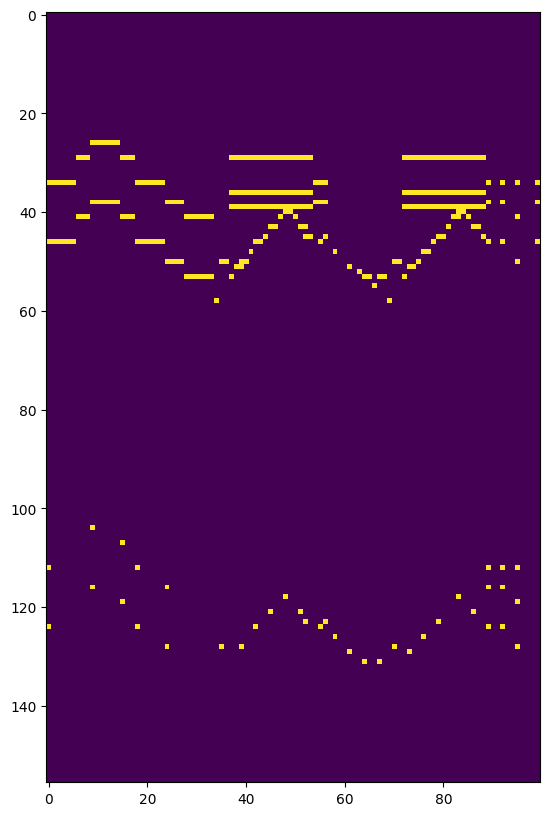

In [61]:
plt.figure(figsize = (20,10))
plt.imshow(100*song[:100,:].T)

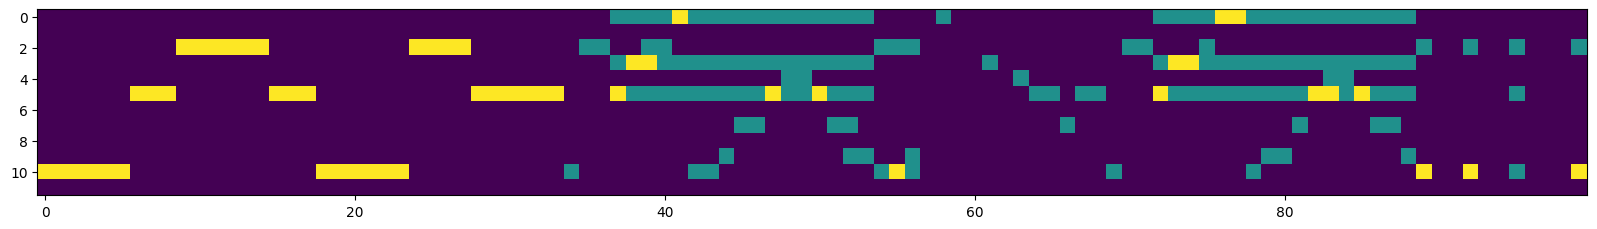

In [62]:
plt.figure(figsize = (20,10))
plt.imshow(100*chroma[:100,:].T)

##### Question 1 [5 points]
Describe what the chromas function does. In your answer refer to musical terms of note names and octave numbers. How does that resemble or differ from the chroma feature that is computed for audio spectrum? Use the figures to demonstrate the explanation.

Hint: Refresh the musical terms by looking at the lecture slides and consider what type of music anaylsis the audio chroma is used for. If you are interested more in musical theory you may also consider the concepts of "pitch class" and "music set theory" that are explained in https://en.wikipedia.org/wiki/Musical_note and https://en.wikipedia.org/wiki/Set_theory_%28music%29

The `add_chromas` function processes the piano roll representation of a song to calculate its chroma features. A chroma feature represents the intensity of each of the 12 pitch classes (C, C#, D, D#, E, F, F#, G, G#, A, A#, B) regardless of the octave. Here's a breakdown of what the function does and its relevance:

1. **Processing Steps**:
   - For each song in the dataset, it initializes a chroma matrix of size `(number of time steps, 12)` with zeros.
   - For each time step, it looks at all 78 possible MIDI note values in the piano roll.
   - If a note is active (value > 0 in the piano roll), it maps the note's MIDI pitch to one of the 12 pitch classes using the modulo operation (`np.mod(j, 12)`).
   - The value for the corresponding pitch class is incremented, resulting in a chroma matrix that sums the contributions of all active notes in that pitch class for each time step.

2. **Musical Terms**:
   - MIDI notes encode both pitch classes and octave numbers. The function, by applying the modulo operation, groups all notes of the same pitch class regardless of their octave.
   - This process abstracts the harmonic content of the music while disregarding octave information, which is central to the concept of chroma in music theory and pitch class.
   - From a perceptual perspective, this approach aligns with pitch class theory in music, where notes differing by octaves are harmonically equivalent.

3. **Comparison to Audio Chroma Features**:
   - **MIDI-Based Chroma:**
     - Directly derived from discrete MIDI note data, making it **exact and unambiguous**.
     - It directly maps notes to pitch classes, ensuring precision in harmonic analysis.
   - **Audio Spectrum Chroma:**
     - Extracted from an audio signal's frequency content using techniques like spectrograms or Mel spectrograms.
     - Relies on estimating the fundamental frequencies and their harmonics, which can introduce ambiguity between octaves and overtones, especially in noisy or polyphonic audio.
   - Both methods focus on pitch classes while ignoring octave-specific details, enabling harmonic content analysis while abstracting away octave information.

4. **Relevance to Music Analysis**:
   - Chroma features are used to capture harmonic and tonal content, which is crucial for tasks such as key detection, chord recognition, and music similarity analysis.
   - In the context of this application, chroma features serve as a reduced representation of the song's harmonic structure, enabling the style transfer model to focus on texture generation while preserving harmonic integrity.
   - This abstraction also highlights key centers, chord progressions, and other harmonic structures that are invariant to octave shifts.

5. **Visualization**:
   - The first figure shows the piano roll matrix, where rows correspond to specific MIDI pitches (78 notes) across time.
   - The second figure shows the chroma matrix, which collapses this representation into 12 pitch classes. This results in a compact, octave-invariant representation that highlights harmonic content.
   - The chroma representation captures harmonic information while ignoring the details of octave-specific variations, making it ideal for modeling the harmonic structure of music while focusing on the texture completion task.


# 2. Setting Up GAN Model

In [63]:
lowest_note = 0 #the index of the lowest note on the piano roll
highest_note = 78 #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 4 #This is the number of timesteps that we will create at a time
X_dim = 2*note_range*num_timesteps #This is the size of the visible layer.
Z_dim = 12*num_timesteps
n_hidden = 50 #This is the size of the hidden layer

print(X_dim,Z_dim)

624 48


##### Question 2 [5 points]

Explain what aspects of music (pitch, rhythm, note duration) are captured by the latent random Z? In your answer refer to the representaiton of the song data. Note how song matrix differs from standard pianoroll.

The latent random variable `Z` captures aspects of **pitch and harmonic content** of the music, as it is directly tied to the chroma features (12 pitch classes) over the specified number of timesteps (`num_timesteps`). Here's the breakdown:

1. **Pitch**:
   - The latent space `Z` is represented as `12 * num_timesteps`, corresponding to the chroma features of the song. Each of the 12 dimensions in `Z` represents the intensity of one of the pitch classes (C, C#, D, etc.) across timesteps.
   - This means `Z` captures the harmonic structure of the music but abstracts away octave-specific details, focusing solely on the relationships between pitch classes.

2. **Rhythm**:
   - The number of timesteps (`num_timesteps`) incorporated into `Z` indirectly encodes rhythmic structure, as it provides a time-dependent progression of chroma features. This allows `Z` to capture rhythmic patterns, such as how chords or harmonies change over time.

3. **Note Duration**:
   - `Z` does not explicitly encode note durations, as this information is more directly represented in the song matrix (or piano roll), which includes continuous note activations over multiple timesteps.
   - However, since `Z` is computed from chroma features aggregated over timesteps, it indirectly reflects note durations through the persistence of pitch class intensities across those timesteps.

### Representation of the Song Data:
- **Song Matrix**:
  - The song matrix (or piano roll) explicitly represents notes as binary activations (or intensities) over a range of 78 MIDI pitches and time steps.
  - It captures **pitch**, **note duration**, and **timing** directly, as each row corresponds to a specific pitch, and consecutive activations of a row represent sustained notes.

- **Chroma Representation in `Z`**:
  - The chroma representation differs from the standard piano roll by collapsing the note range into 12 pitch classes, abstracting away the octave-specific information.
  - While this abstraction makes `Z` less detailed regarding specific pitches or note durations, it provides a concise representation of harmonic content over time, which is the key focus for style transfer in this application.

In summary, `Z` primarily captures **pitch and harmonic structure**, with some indirect representation of rhythm through time-dependent chroma features. However, it does not explicitly encode note durations or the full detail of the piano roll data. The abstraction is well-suited for style transfer, where harmonic relationships and rhythmic progression are more important than exact note timing or durations.


In [64]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [65]:
tf.disable_v2_behavior()

#setting up model, discriminator weights and biases
X = tf.placeholder(tf.float32, shape=[None, X_dim])


D_W1 = tf.Variable(xavier_init([X_dim+Z_dim, 512]))
D_b1 = tf.Variable(tf.zeros(shape=[512]))

D_W2 = tf.Variable(xavier_init([512, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Instructions for updating:
non-resource variables are not supported in the long term


In [66]:
#setting up model, generator weights and biases

#z is the space we're generating from
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim])) 


theta_G = [G_W1, G_W2, G_b1, G_b2]

In [67]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [68]:
def discriminator(x,c):
    D_h1 = tf.nn.relu(tf.matmul(tf.concat([x,c],1), D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [69]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        plt.imshow(sample.reshape(78, 30), cmap='Greys_r')


    return fig

In [70]:
G_sample = generator(Z)

In [71]:
D_real, D_logit_real = discriminator(X,Z)

In [72]:
D_fake, D_logit_fake = discriminator(G_sample,Z)

##### Question 3 [10 points]
In standard GAN, the discriminator receives as input true or fake (generated) data only. Explain why in our case the disrciminator receives as input both the data and an additional variable Z? How this Z differs from the usual GAN input of a random vector?

In this implementation, the discriminator receives both the data (`X`) and the additional variable `Z` as inputs. Here's why this design is different from a standard GAN and how it serves the specific purpose of this model:

1. **Why the Discriminator Receives `Z`**:
   - In a standard GAN, the discriminator determines whether a given sample is real (from the dataset) or fake (generated by the generator) based solely on the sample itself.
   - In this case, the discriminator also receives the latent variable `Z` as input because `Z` carries contextual information that the generator uses to create the fake data.
   - The role of the discriminator is not just to evaluate the authenticity of the generated data (`X`), but also to verify whether the generated data aligns harmoniously with the given latent variable `Z`.

2. **Purpose of `Z` in This Model**:
   - Here, `Z` is not a random vector as in standard GANs; it is a structured latent space representing chroma features (harmonic information) over a fixed number of timesteps.
   - The generator uses `Z` to generate a piano roll-like texture that complements the harmonic structure described by `Z`. The discriminator evaluates whether the generated piano roll (or real data) is consistent with the harmonic structure in `Z`.
   - By incorporating `Z` as an input to the discriminator, the model enforces a relationship between the generated texture and the harmonic content. This ensures that the generator learns to create data that not only looks realistic but also matches the specified harmonic context.

3. **How This Differs from a Standard GAN**:
   - In standard GANs:
     - The latent input `Z` is a random vector sampled from a distribution (e.g., Gaussian or uniform) and does not have a direct interpretive or contextual link to the real data.
     - The discriminator evaluates samples independently of `Z`.
   - In this implementation:
     - `Z` is not random but represents meaningful harmonic information derived from the song's chroma features.
     - The discriminator evaluates samples in conjunction with `Z` to ensure that the generated texture aligns with the harmonic structure specified by `Z`.

4. **Advantages of This Approach**:
   - This approach creates a **conditional GAN (cGAN)**, where the generator is conditioned on `Z`. It allows for controlled generation based on the harmonic structure, making it possible to generate specific textures corresponding to different chroma features.
   - By incorporating `Z` into the discriminator, the model explicitly enforces the condition that the generated data must not only appear realistic but also adhere to the harmonic structure described by `Z`.

In summary, the inclusion of `Z` in the discriminator ensures that the generated musical textures are consistent with the harmonic structure represented by `Z`, making this a conditional GAN designed to model both the harmonic and textural elements of music.


In [73]:

# Alternative losses:
# -------------------
Lambda = 100
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_loss_L1 = tf.reduce_mean(tf.losses.mean_squared_error(X,G_sample))
G_loss = G_loss_fake + Lambda*G_loss_L1

##### Question 4 [10 points]
Explain the two components of the discriminator loss in the D_loss expression. Why the real loss uses tf.ones_like andthe fake loss uses tf.zeros_like in the cross entory loss? What are the statistical distributions (which datasets are used) in computational of the real and fake losses. In your answers you may either include an equation image or write the loss equaiton in latex mathamtical notation inside Markdown cell.

# Discriminator Loss (`D_loss`) Explanation

The discriminator loss (`D_loss`) consists of two components: `D_loss_real` and `D_loss_fake`.

## 1. Discriminator Loss Components
- **`D_loss_real`:**
  - This term represents the loss for correctly classifying real data as real.
  - It is calculated as the cross-entropy loss between the discriminator's output logits for real data (`D_logit_real`) and a label of 1 (real), using `tf.ones_like(D_logit_real)` to generate a tensor of ones.
  - Mathematically:

    $D_{\text{loss real}}  = -\frac{1}{N} \sum_{i=1}^{N} \log(D(x_i, z_i))$

    Here:
    - $D(x_i, z_i)$ is the probability output by the discriminator for real data $x_i$ and context $z_i$.

- **`D_loss_fake`:**
  - This term represents the loss for correctly classifying fake (generated) data as fake.
  - It is calculated as the cross-entropy loss between the discriminator's output logits for fake data (`D_logit_fake`) and a label of 0 (fake), using `tf.zeros_like(D_logit_fake)` to generate a tensor of zeros.
  - Mathematically:
$
    D_{\text{loss fake}} = -\frac{1}{N} \sum_{i=1}^{N} \log(1 - D(G(z_i), z_i))
$
    Here:
    - $G(z_i)$ is the generated data using latent vector $z_i$.
    - $D(G(z_i), z_i)$ is the discriminator's probability output for fake data.

- **Total Discriminator Loss:**
  $$
  D_{\text{loss}} = D_{\text{loss real}} + D_{\text{loss fake}}
  $$

## 2. Why `tf.ones_like` and `tf.zeros_like` Are Used
- **Purpose:**
  - In GANs, the discriminator's job is to distinguish between real and fake data.
  - To achieve this:
    - Real data is labeled with `1` to encourage the discriminator to predict high probabilities for real samples.
    - Fake data is labeled with `0` to encourage the discriminator to predict low probabilities for generated samples.
- **Implementation:**
  - `tf.ones_like` generates a tensor of ones (matching the shape of the logits) for real data labels.
  - `tf.zeros_like` generates a tensor of zeros (matching the shape of the logits) for fake data labels.

## 3. Statistical Distributions in Real and Fake Losses
- `D_loss_real` is computed on **real data** (from the dataset), ensuring the discriminator correctly classifies real data as real.
- `D_loss_fake` is computed on **fake data** (generated by the generator), ensuring the discriminator correctly classifies fake data as fake.


##### Question 5 [10 points]
In the generator loss G_loss we add an L1 loss. What does it represent? Why do you think we might want to add the L1 loss to the GAN model? We will explore this question further down the assignment, so at this point write down your best explanation based on the equations themselves without running any experiments.

The generator loss (`G_loss`) in this implementation includes two components: the adversarial loss (`G_loss_fake`) and an additional L1 loss (`G_loss_L1`). Here's an explanation of what the L1 loss represents and why it is added to the GAN model:

### 1. What the L1 Loss Represents:
- The L1 loss, calculated as the mean squared error between the real data ($X$) and the generated data ($G(z)$), measures the **reconstruction error** or **closeness** of the generated data to the real data.
- Mathematically:
  $$
  G_{\text{loss L1}} = \frac{1}{N} \sum_{i=1}^{N} \| X_i - G(z_i) \|_1
  $$
  where $X_i$ is the real data, $G(z_i)$ is the generator's output, and $\| \cdot \|_1$ represents the L1 norm.
- This term explicitly encourages the generator to produce outputs that closely match the real data, in addition to fooling the discriminator.

### 2. Why Add the L1 Loss:
- **Stabilizing Training**: In GANs, the adversarial loss ($G_{\text{loss fake}}$) can be unstable because it depends on the discriminator's feedback, which may oscillate during training. Adding the L1 loss provides a direct and stable gradient for the generator, helping it learn faster and reducing instability.
- **Improving Output Quality**: The adversarial loss alone ensures that the generator produces realistic-looking data that can fool the discriminator, but it does not guarantee that the generated data is similar to the real data. The L1 loss enforces this similarity, ensuring that the generator captures important structural details of the data.
- **Alignment with Ground Truth**: In this specific use case, the goal is not just to generate any plausible musical texture but to generate textures that align with the real data's structure (e.g., harmonics and chroma features). The L1 loss enforces this alignment by directly penalizing large differences between the generated and real data.

### 3. Combination of Losses:
- The total generator loss is:
  $$
  G_{\text{loss}} = G_{\text{loss fake}} + \lambda \cdot G_{\text{loss L1}}
  $$
  where $\lambda$ is a weight that controls the trade-off between the adversarial loss and the L1 loss. A higher $\lambda$ places more emphasis on the L1 loss.
- The adversarial loss pushes the generator to create realistic outputs that can fool the discriminator, while the L1 loss ensures these outputs are also consistent with the real data.

### 4. Why L1 Loss Instead of L2:
- L1 loss is often preferred over L2 loss in tasks involving image or texture generation because it tends to produce sharper and more detailed outputs. L2 loss, which penalizes the squared differences, can lead to overly smooth outputs, as it minimizes large differences more aggressively.


In summary, the L1 loss in `G_loss` represents the similarity between the generated and real data. It is added to the GAN model to stabilize training, improve output quality, and ensure that the generated data aligns with the structure of the real data. This is particularly important in tasks where preserving specific features, like harmonic structure, is critical.


In [74]:
#optimizing functions
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [75]:
#output midi file folder
if not os.path.exists('out/'):
    os.makedirs('out/')

In [76]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

I0000 00:00:1737724981.052052 40677991 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


# 3. Training GAN Model

In [77]:
i = 0
num_epochs = 200000
batch_size = 100
S_cutoff = 0.5
#commented out print statements output different losses, and plotting functions plot the piano roll and chroma.
while i <= num_epochs:
    # for song, chroma in zip(songs, chromas):
    for files in songs:
        song = songs[files]['song']
        chroma = songs[files]['chroma']
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
        song = np.array(song)
        song_steps = np.floor(song.shape[0]/num_timesteps).astype(int)
        song = song[:song_steps*num_timesteps]
        song = np.reshape(song, [song_steps, song.shape[1]*num_timesteps])
        chroma = np.array(chroma)
        chroma = chroma[:song_steps*num_timesteps]
        chroma = np.reshape(chroma, [song_steps, chroma.shape[1]*num_timesteps])
        batch_size = min(batch_size,len(song))
        # Train the RBM on batch_size examples at a time
        for ind in range(0, len(song), batch_size):
            X_mb = song[ind:ind+batch_size]
            ch = chroma[ind:ind+batch_size]
            _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: ch})
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: ch})

            if i % 1000 == 0:
                print('Iter: {}'.format(i))
                dloss = ('D_Loss: {:.4}'. format(D_loss_curr))
                gloss = ('G_Loss: {:.4}'. format(G_loss_curr))
                print(dloss)
                print(gloss)

                samples = sess.run(G_sample, feed_dict={Z: ch})

                S = np.reshape(samples, (ch.shape[0]*num_timesteps, 2*note_range))
                thresh_S = S>=S_cutoff

                thresh_S = np.transpose(thresh_S)


                C = np.reshape(ch, (ch.shape[0]*num_timesteps, 12))

                test = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
                test.write('out/{}.mid'.format(i))

            i += 1

Iter: 0
D_Loss: 1.299
G_Loss: 31.39
Iter: 1000
D_Loss: 0.0523
G_Loss: 8.102
Iter: 2000
D_Loss: 0.3343
G_Loss: 6.194
Iter: 3000
D_Loss: 0.01254
G_Loss: 14.29
Iter: 4000
D_Loss: 0.0007048
G_Loss: 13.96
Iter: 5000
D_Loss: 0.0006468
G_Loss: 16.16
Iter: 6000
D_Loss: 0.0009911
G_Loss: 12.66
Iter: 7000
D_Loss: 7.67e-05
G_Loss: 15.3
Iter: 8000
D_Loss: 8.486e-06
G_Loss: 17.82
Iter: 9000
D_Loss: 2.723e-06
G_Loss: 23.21
Iter: 10000
D_Loss: 2.098e-05
G_Loss: 18.03
Iter: 11000
D_Loss: 7.211e-06
G_Loss: 16.32
Iter: 12000
D_Loss: 3.186e-06
G_Loss: 20.38
Iter: 13000
D_Loss: 2.837e-05
G_Loss: 16.88
Iter: 14000
D_Loss: 1.734e-06
G_Loss: 19.2
Iter: 15000
D_Loss: 8.238e-08
G_Loss: 24.41
Iter: 16000
D_Loss: 9.854e-07
G_Loss: 24.54
Iter: 17000
D_Loss: 5.728e-07
G_Loss: 30.16
Iter: 18000
D_Loss: 3.817e-07
G_Loss: 35.01
Iter: 19000
D_Loss: 3.088e-07
G_Loss: 35.13
Iter: 20000
D_Loss: 4.792e-08
G_Loss: 34.7
Iter: 21000
D_Loss: 8.818e-08
G_Loss: 25.04
Iter: 22000
D_Loss: 2.502e-09
G_Loss: 30.27
Iter: 23000
D_Los

# 4. Style Transfer with a New Genre Dataset

In this part we will explore using the trained GAN to compose new music according to the harmonic structure of another musical input. In a way this comprises of a style transfer between the input music that belongs to style A and the output music that is generated using GAN trained on style B. In the example we will used J.S.Bach as our input (Style A) and output music in Mozart's style that was use to train our GAN (Style B). The new Mozart piece should follow the harmonic structure (chord progressions) of the Bach input.

In [78]:
#for testing, we will be using a different composer dataset to input into the generator here.
test_song = get_songs("./Classical_Music_Midi/bach")
test_song = add_chromas(test_song)

print ("{} songs processed".format(len(['song' in test_song[f] for f in test_song])))
print ("{} chromas processed".format(len(['chroma' in test_song[f] for f in test_song])))

3 songs processed
3 chromas processed


In [79]:
#converted midi file folder
if not os.path.exists('converted/'):
    os.makedirs('converted/')

In [80]:
i = 0
S_cutoff = 0.5

# for i,c in enumerate(test_chromaz):
for song in test_song:
    test_chroma = np.array(test_song[song]['chroma'])

    test_chroma = test_chroma[:np.floor(test_chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
    test_chroma = np.reshape(test_chroma, [int(test_chroma.shape[0]/num_timesteps), test_chroma.shape[1]*num_timesteps])

    out_samples = sess.run(G_sample, feed_dict={Z: test_chroma})

    S = np.reshape(out_samples, (np.floor(out_samples.shape[0]*out_samples.shape[1]/2/note_range).astype(int), 2*note_range))
    C = np.reshape(test_chroma, (test_chroma.shape[0]*num_timesteps, 12))

    thresh_S = S>=S_cutoff
    thresh_S = np.transpose(thresh_S)

    test = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
    test_song[song]['generated'] = test
    test.write('converted/{}.mid'.format(song.split('/')[-1].split('.')[0]+"generated"))



##### Question 6 [10 points]
Open the conversion results in a musical MIDI software (such as Musescore) and observe/listen to the results. Write down your impressions about the quality of the musical texture style transfer - did the harmonic structure follow the Bach input? How did the notes distribution (choice of pitches and durations) change relative to the original Bach piece? Does the S_cutoff parameter affect the outcome, and if so, how?

Summarize your findings and suggest some conclusions. Can you point to any musical aspects that were poorly modeled and ideas of improvement?

After analyzing and listening to the output generated by the model and comparing it to the original input, several observations can be made:

#### 1. Harmonic Quality
The generated piece struggles to preserve the harmonic structure of the original input. One of the hallmarks of the original is the smooth progression of chords. These qualities are not consistently maintained in the generated output.

However, the generated piece exhibits a certain repetitive pattern every seven seconds, suggesting that the model learned some form of structure. This repetition may point to an attempt to establish a harmonic framework. While this provides some coherence, the lack of accurate harmonic transitions results in an overall experience that feels disconnected from the original style.

#### 2. Musical Texture
The texture in the generated output is noticeably denser than in the original. While the original balances melody and harmony with elegance, the generated piece overloads the listener with an excess of notes. This increase in note density creates a sense of heaviness and detracts from the clarity and simplicity that define the original piece.

Many extra notes appear throughout the generated piece, which disrupts the natural flow of the music. This over-saturation of notes contributes to a feeling of "musical clutter."

#### 3. Unnatural Elements
Several sections of the generated output contain notes that sound out of context. These notes do not align with the harmonic or melodic language of the original, nor do they convincingly emulate the style of the intended transformation. This issue is particularly noticeable in transitional areas, where the generated piece introduces jarring and seemingly arbitrary notes that disrupt the continuity.

Additionally, the melody in the generated piece lacks fidelity to the original. It often veers off course, failing to capture the essence of the melodic lines and occasionally introducing awkward phrasing or imbalances between different musical voices.

#### 4. Impact of the `S_cutoff` Parameter
The excess of notes in the generated output suggests that the `S_cutoff` parameter may have been set too low. A lower cutoff value could lead the model to include more notes than necessary, resulting in a denser texture and the addition of extraneous elements. Adjusting this parameter to a higher value could potentially filter out these unnecessary notes and produce a cleaner, more structured output.

# Conclusions and Recommendations

Based on these observations, the following improvements are suggested:

1. **Enhancing Harmonic Accuracy:**
   The model should be trained on a more extensive and diverse dataset, including a greater variety of harmonic progressions and stylistic nuances. This could help it better understand and replicate the intricate harmonic structures characteristic of classical compositions.

2. **Balancing the Texture:**
   To address the issue of note overload, the model could incorporate mechanisms to limit excessive note generation. For example:
   - Fine-tuning the `S_cutoff` parameter to optimize note selection.
   - Implementing a loss function that penalizes over-saturation of notes, such as one based on the L1 or L2 norms.

3. **Improving Melody Preservation:**
   The melodic lines could be better preserved by integrating attention mechanisms into the model. These mechanisms can help the model focus on key melodic patterns while avoiding the introduction of irrelevant notes. Additionally, incorporating a specialized module for melody and harmony generation might improve the balance between these elements.

4. **Addressing Repetition:**
   While some repetition is beneficial for coherence, excessive repetition can make the output feel monotonous. Training the model with data that includes more varied patterns and transitions could help reduce this issue.




# 5. Further experiments

##### Question 7 & 8: [total 30 points]

Choose two of the experiments and report their results:

1. Explore style transfer between more distant styles: For this purpose you may use the Pop_Music_Midi dataset and repeat the Style Transfer Experiment between Classical and Pop music (and vice versa). Report your findings in qualitative ways and submit the midi results together with your explanation. [20 Points]

2. Expermment with L1 distance: retrain the GAN model with very small and very large Lambda. What are the effects of such changes? When is the texture of the output more or less musical? Are the harmonic progressions of the input followed or ignored? Any other observations? [20 Points]

3. Create your own song: use the leadsheet2chroma.py file provided to create a Mozart style composition from your own leadsheet input. Provide the leadsheet in text format and the midi file results. Report your observations about the musical quality of the results. You may alter the leadsheet2chroma.py to fit other chords if you wish, or train GAN in a style different then Mozart. [20 Points]



# Question 7

In [130]:
# Load Pop Music Dataset
pop_songs = get_songs('./Pop_Music_Midi/')
pop_songs = add_chromas(pop_songs)
print(f"{len(pop_songs)} pop songs processed.")

# Style Transfer: Classical to Pop
test_song_classical = get_songs("./Classical_Music_Midi/mozart")
test_song_classical = add_chromas(test_song_classical)

for song in test_song_classical:
    test_chroma = np.array(test_song_classical[song]['chroma'])

    test_chroma = test_chroma[:np.floor(test_chroma.shape[0] / num_timesteps).astype(int) * num_timesteps]
    test_chroma = np.reshape(test_chroma, [int(test_chroma.shape[0] / num_timesteps), test_chroma.shape[1] * num_timesteps])

    out_samples = sess.run(G_sample, feed_dict={Z: test_chroma})

    S = np.reshape(out_samples, (np.floor(out_samples.shape[0] * out_samples.shape[1] / 2 / note_range).astype(int), 2 * note_range))
    thresh_S = S >= S_cutoff
    thresh_S = np.transpose(thresh_S)

    generated_midi = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
    generated_midi.write(f'converted/{song.split("/")[-1].split(".")[0]}_to_pop.mid')

print("Style transfer Classical -> Pop completed.")

# Style Transfer: Pop to Classical
for song in pop_songs:
    test_chroma = np.array(pop_songs[song]['chroma'])

    test_chroma = test_chroma[:np.floor(test_chroma.shape[0] / num_timesteps).astype(int) * num_timesteps]
    test_chroma = np.reshape(test_chroma, [int(test_chroma.shape[0] / num_timesteps), test_chroma.shape[1] * num_timesteps])

    out_samples = sess.run(G_sample, feed_dict={Z: test_chroma})

    S = np.reshape(out_samples, (np.floor(out_samples.shape[0] * out_samples.shape[1] / 2 / note_range).astype(int), 2 * note_range))
    thresh_S = S >= S_cutoff
    thresh_S = np.transpose(thresh_S)

    generated_midi = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
    generated_midi.write(f'converted/{song.split("/")[-1].split(".")[0]}_to_classical.mid')

print("Style transfer Pop -> Classical completed.")


122 pop songs processed.
Style transfer Classical -> Pop completed.
Style transfer Pop -> Classical completed.


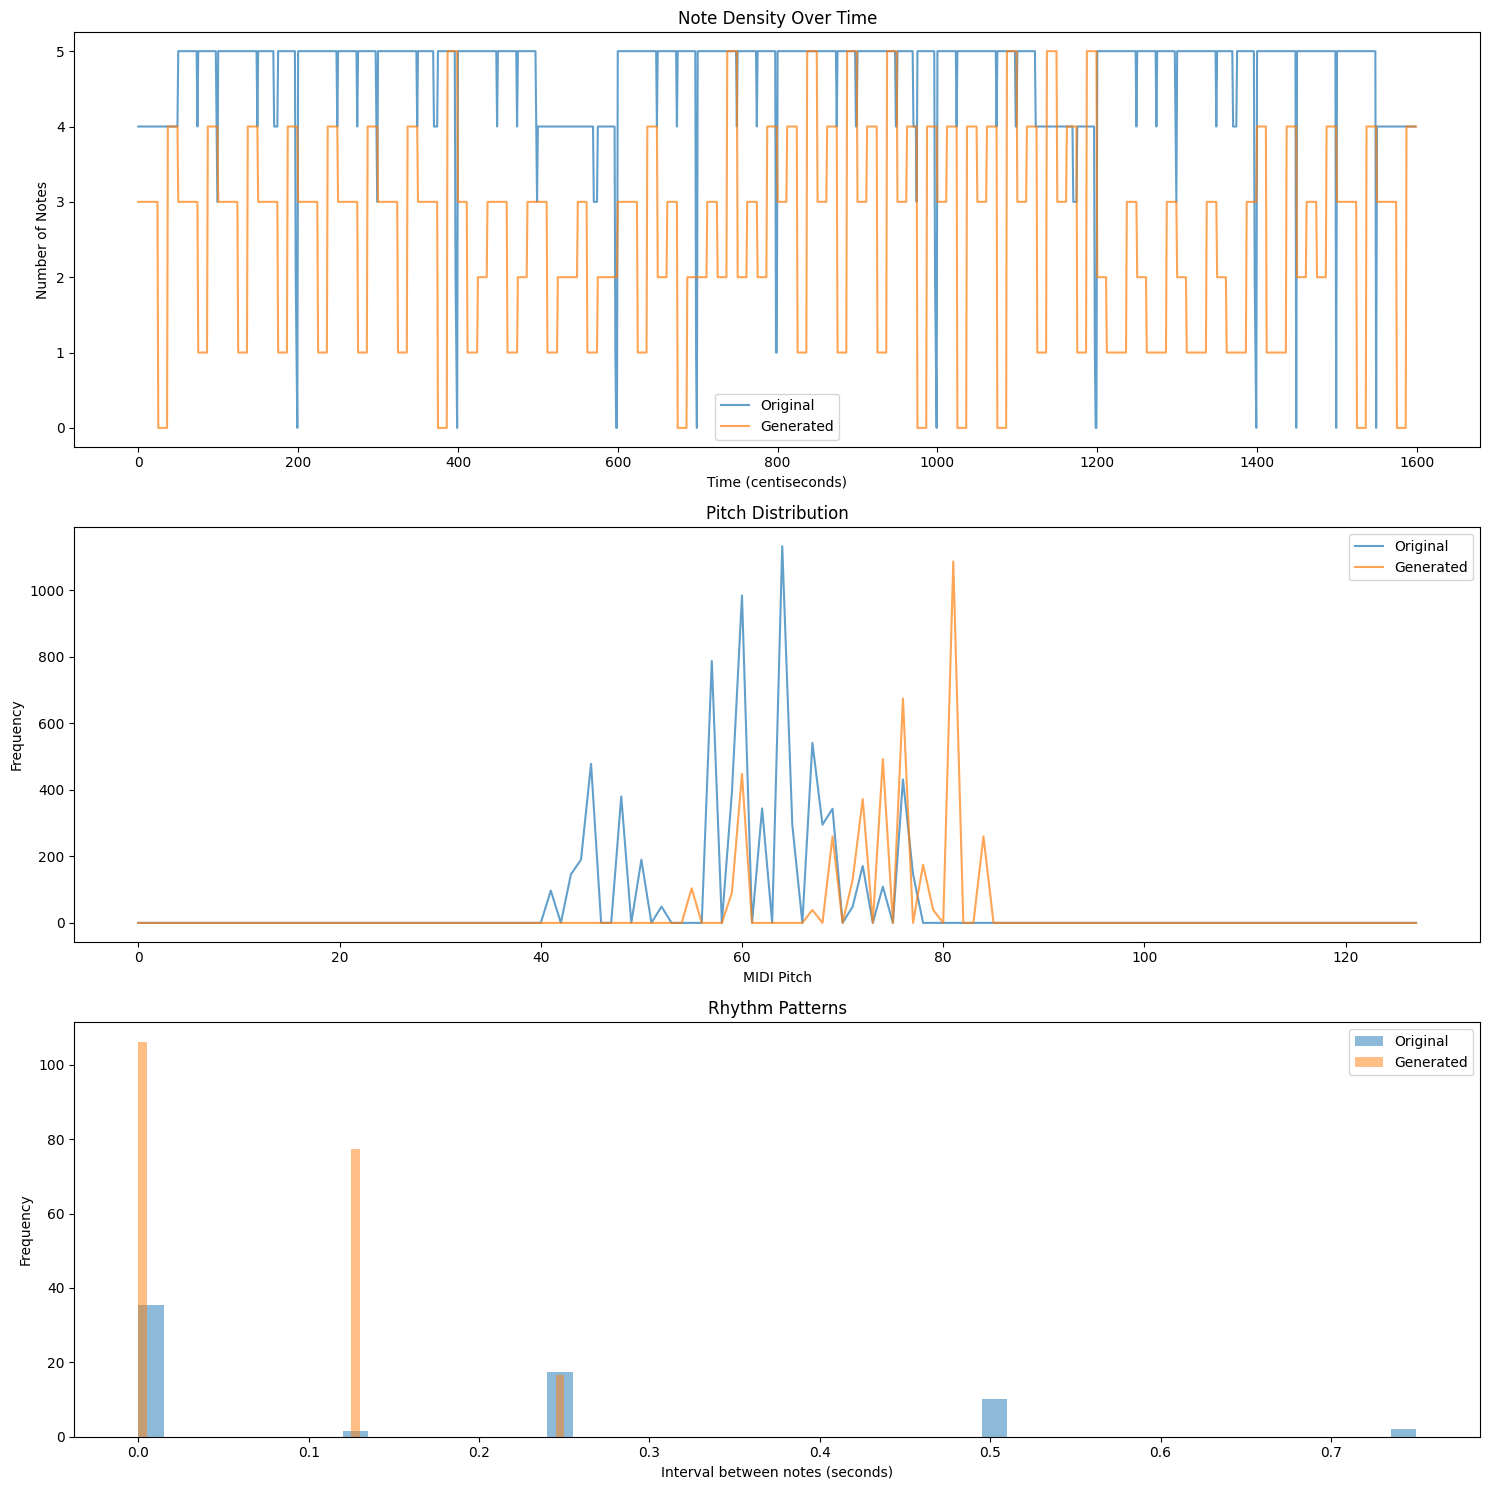

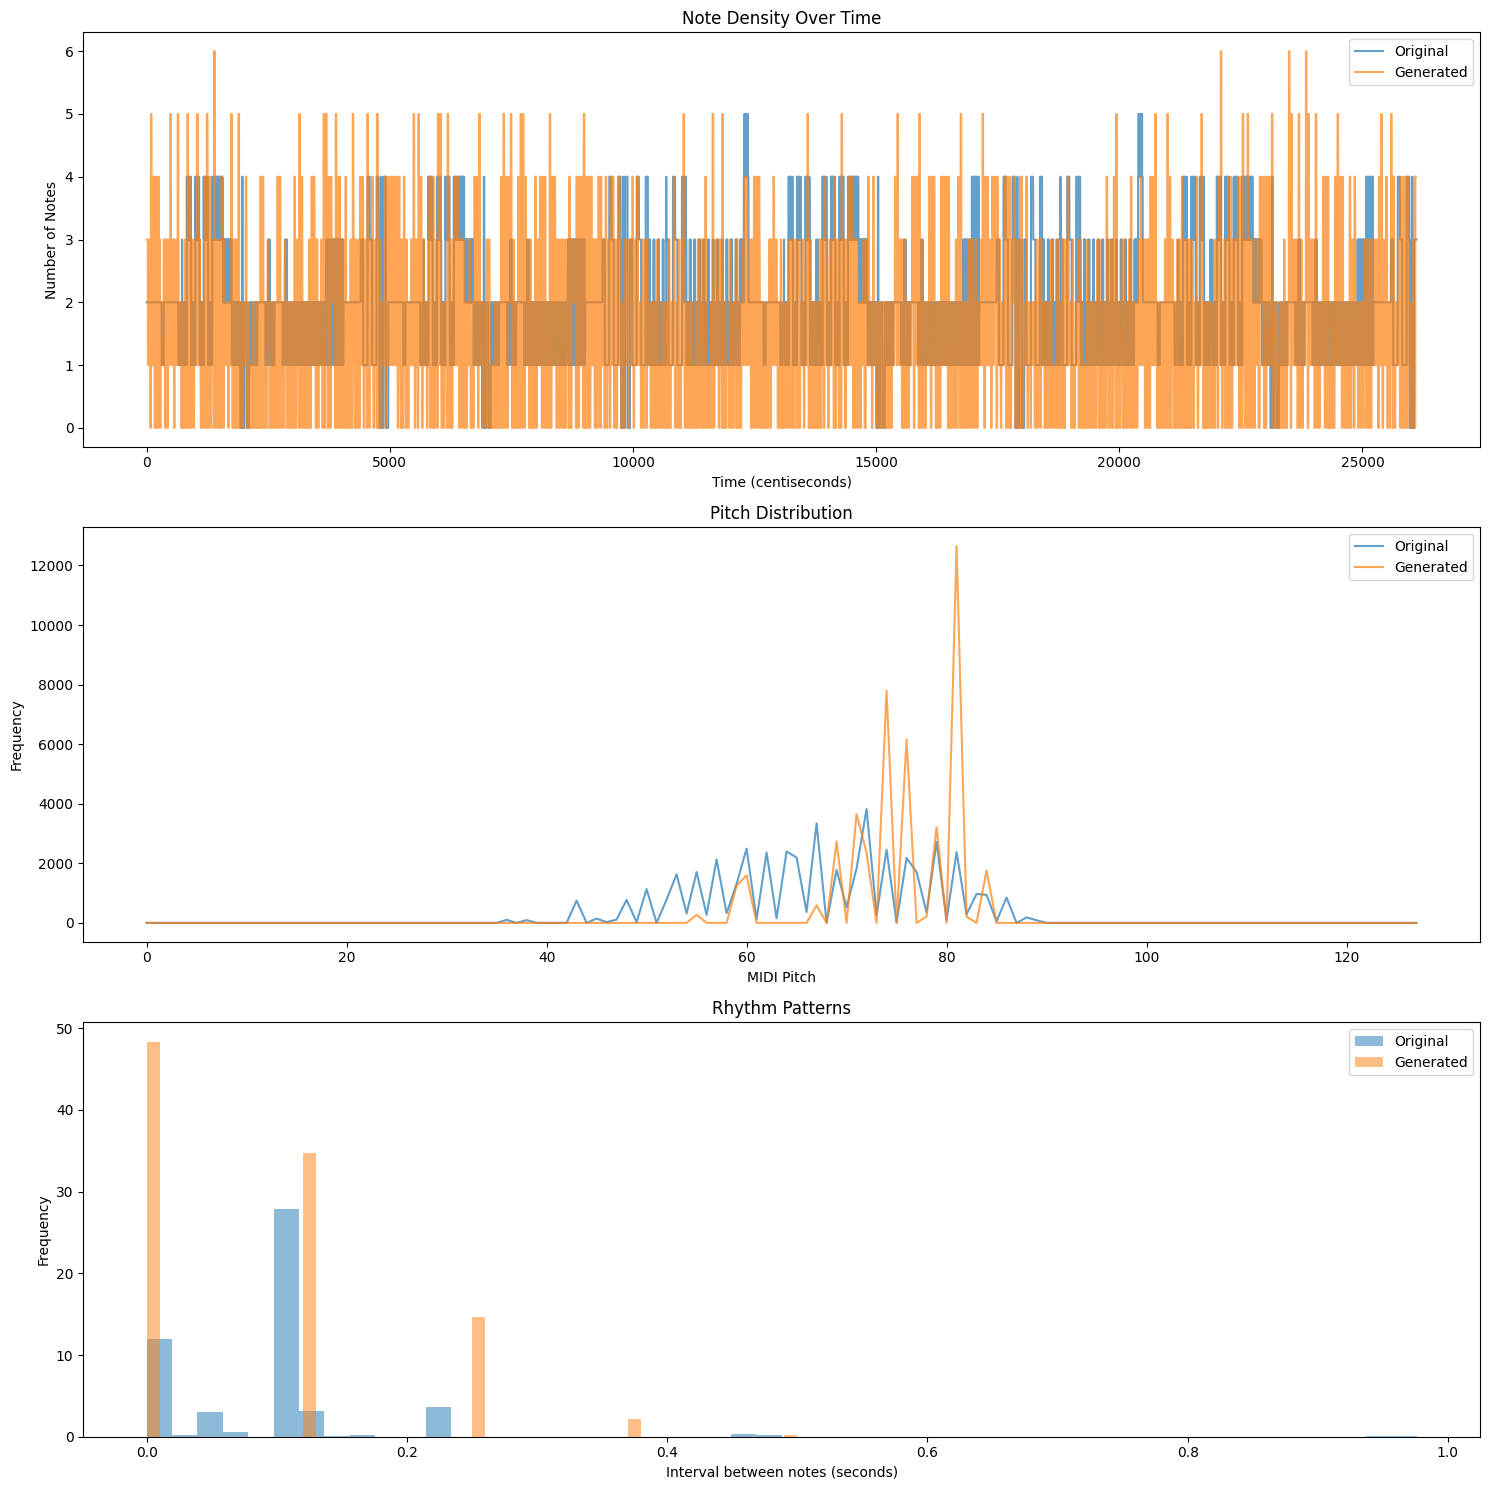

In [132]:
import pretty_midi
import matplotlib.pyplot as plt
import numpy as np

# Function to analyze a MIDI file
def analyze_midi(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    fs = 100  # Sampling rate for piano roll
    piano_roll = pm.get_piano_roll(fs=fs)

    note_density = np.sum(piano_roll > 0, axis=0)
    pitch_range = np.sum(piano_roll > 0, axis=1)

    onsets = []
    for instrument in pm.instruments:
        for note in instrument.notes:
            onsets.append(note.start)
    onsets = np.array(sorted(onsets))

    intervals = np.diff(onsets) if len(onsets) > 1 else np.array([])

    return {
        'note_density': note_density,
        'pitch_range': pitch_range,
        'duration': pm.get_end_time(),
        'intervals': intervals,
        'onsets': onsets
    }

# Function to plot analysis graphs
def plot_analysis(features_original, features_generated, labels):
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))

    # Note density over time
    axs[0].plot(features_original['note_density'], label=labels['original'], alpha=0.7)
    axs[0].plot(features_generated['note_density'], label=labels['generated'], alpha=0.7)
    axs[0].set_title("Note Density Over Time")
    axs[0].set_xlabel("Time (centiseconds)")
    axs[0].set_ylabel("Number of Notes")
    axs[0].legend()

    # Pitch distribution
    axs[1].plot(features_original['pitch_range'], label=labels['original'], alpha=0.7)
    axs[1].plot(features_generated['pitch_range'], label=labels['generated'], alpha=0.7)
    axs[1].set_title("Pitch Distribution")
    axs[1].set_xlabel("MIDI Pitch")
    axs[1].set_ylabel("Frequency")
    axs[1].legend()

    # Rhythm patterns
    axs[2].hist(features_original['intervals'], bins=50, alpha=0.5, label=labels['original'], density=True)
    axs[2].hist(features_generated['intervals'], bins=50, alpha=0.5, label=labels['generated'], density=True)
    axs[2].set_title("Rhythm Patterns")
    axs[2].set_xlabel("Interval between notes (seconds)")
    axs[2].set_ylabel("Frequency")
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# Function to compare MIDI files
def compare_midi(original_file, generated_file):
    features_original = analyze_midi(original_file)
    features_generated = analyze_midi(generated_file)

    labels = {
        'original': 'Original',
        'generated': 'Generated'
    }

    plot_analysis(features_original, features_generated, labels)

# Example adapted for existing files
compare_midi('Pop_Music_Midi/Baby One More Time - Chorus.midi', 
             'converted/Baby One More Time - Chorus_to_classical.mid')

compare_midi('Classical_Music_Midi/mozart/mz_545_1.mid', 
             'converted/mz_545_1_to_pop.mid')


# Style Transfer Exploration Between Classical and Pop Music
## Experiment Overview

The experiment aimed to explore style transfer between Classical and Pop music using a GAN-based model. The generated outputs revealed interesting insights into the model's ability to transfer stylistic elements while preserving the harmonic and rhythmic structure of the original compositions.

## Observations

### Harmonic Quality
The GAN demonstrated success in capturing and replicating harmonic patterns from the original pieces, particularly the foundational chords and underlying structure.  
Challenges:
- Rhythmic and melodic elements presented greater challenges.
- Generated files often displayed variations in note density:
  - Some parts felt overly dense, while others lacked balance and consistency.
- Suggests that while the model can preserve broad stylistic characteristics, it struggles with temporal coherence.

### Melodic Patterns
The generated outputs showcased a broader pitch range than the originals.  
Issues:
- Occasionally led to unnatural transitions or an overemphasis on specific notes.
- Highlights a potential issue with the model's ability to balance variety and coherence:
- Tends to exaggerate certain features while neglecting others.

### Rhythmic Consistency
Rhythmically, the generated music often featured tighter intervals between notes, creating a rushed and less natural flow.  
Indicates that the model may not fully capture the temporal dynamics of the target genre, resulting in a mechanical feel rather than an organic flow.

## Key Takeaways

### Strengths
- The model effectively captured harmonic structures.
- Successfully transferred key stylistic traits between Classical and Pop genres.

### Weaknesses
- Rhythmic and melodic consistency were less reliable, with notable deviations from the natural flow of the original pieces.

## Potential Improvements
1. Adjust the `S_cutoff` parameter to refine note density and achieve a more balanced output.
2. Train the model on a larger and more diverse dataset to improve its understanding of temporal and melodic dynamics across genres.


# Question 8

In [165]:
import os
import numpy as np
import tensorflow.compat.v1 as tf
from reverse_pianoroll import piano_roll_to_pretty_midi
from convert import back

# Disable TensorFlow 2.x behavior
tf.disable_v2_behavior()

# Parameters
num_timesteps = 4
note_range = 78
X_dim = 2 * note_range * num_timesteps
Z_dim = 12 * num_timesteps
n_hidden = 50
num_epochs = 200000
batch_size = 100
S_cutoff = 0.5

# Placeholder definitions
X = tf.placeholder(tf.float32, shape=[None, X_dim], name="X")
Z = tf.placeholder(tf.float32, shape=[None, Z_dim], name="Z")

# Xavier initialization
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

# Model parameters
D_W1 = tf.Variable(xavier_init([X_dim + Z_dim, 512]))
D_b1 = tf.Variable(tf.zeros(shape=[512]))
D_W2 = tf.Variable(xavier_init([512, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))
theta_D = [D_W1, D_W2, D_b1, D_b2]

G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))
G_W2 = tf.Variable(xavier_init([128, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))
theta_G = [G_W1, G_W2, G_b1, G_b2]

# Generator and discriminator functions
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob

def discriminator(x, c):
    D_h1 = tf.nn.relu(tf.matmul(tf.concat([x, c], axis=1), D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    return D_prob, D_logit

# Training function for each Lambda
def train_gan(Lambda, output_dir):
    print(f"Training with Lambda = {Lambda}")
    # Loss functions
    G_sample = generator(Z)
    D_real, D_logit_real = discriminator(X, Z)
    D_fake, D_logit_fake = discriminator(G_sample, Z)

    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
    D_loss = D_loss_real + D_loss_fake

    G_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
    G_loss_L1 = tf.reduce_mean(tf.losses.mean_squared_error(X, G_sample))
    G_loss = G_loss_fake + Lambda * G_loss_L1

    # Optimizers
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

    # Create output directory
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Training loop
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        i = 0
        while i <= num_epochs:
            for files in songs:
                song = songs[files]['song']
                chroma = songs[files]['chroma']

                # Reshape data
                song = np.array(song)
                song_steps = np.floor(song.shape[0] / num_timesteps).astype(int)
                song = song[:song_steps * num_timesteps]
                song = np.reshape(song, [song_steps, song.shape[1] * num_timesteps])

                chroma = np.array(chroma)
                chroma = chroma[:song_steps * num_timesteps]
                chroma = np.reshape(chroma, [song_steps, chroma.shape[1] * num_timesteps])

                effective_batch_size = min(batch_size, len(song))
                for ind in range(0, len(song), effective_batch_size):
                    X_mb = song[ind:ind + effective_batch_size]
                    ch = chroma[ind:ind + effective_batch_size]

                    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: ch})
                    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: ch})

                    if i % 5000 == 0:  # Print and save results every 5000 iterations
                        print(f"Iter: {i}, D_Loss: {D_loss_curr:.4e}, G_Loss: {G_loss_curr:.4f}")
                        samples = sess.run(G_sample, feed_dict={Z: ch})

                        S = np.reshape(samples, (ch.shape[0] * num_timesteps, 2 * note_range))
                        thresh_S = S >= S_cutoff
                        thresh_S = np.transpose(thresh_S)

                        generated_midi = piano_roll_to_pretty_midi(back(thresh_S), fs=16)
                        generated_midi.write(f"{output_dir}/{i}.mid")
                    i += 1

# Train with small Lambda
train_gan(0.0001, "Results_Lambda_0.0001")

# Train with large Lambda
train_gan(1000, "Results_Lambda_1000")


Training with Lambda = 0.0001
Iter: 0, D_Loss: 1.2132e+00, G_Loss: 4.5061
Iter: 5000, D_Loss: 2.2103e-04, G_Loss: 9.6704
Iter: 10000, D_Loss: 5.1303e-06, G_Loss: 13.9874
Iter: 15000, D_Loss: 3.4118e-08, G_Loss: 21.2868
Iter: 20000, D_Loss: 6.6612e-07, G_Loss: 20.3807
Iter: 25000, D_Loss: 1.9521e-08, G_Loss: 20.7084
Iter: 30000, D_Loss: 2.3155e-06, G_Loss: 20.2703
Iter: 35000, D_Loss: 2.8531e-09, G_Loss: 28.5615
Iter: 40000, D_Loss: 2.5146e-08, G_Loss: 28.3857
Iter: 45000, D_Loss: 2.8114e-11, G_Loss: 30.4689
Iter: 50000, D_Loss: 4.3360e-09, G_Loss: 29.2329
Iter: 55000, D_Loss: 1.0474e-08, G_Loss: 23.6721
Iter: 60000, D_Loss: 1.9815e-10, G_Loss: 28.9877
Iter: 65000, D_Loss: 3.5062e-11, G_Loss: 80.0468
Iter: 70000, D_Loss: 4.2454e-11, G_Loss: 28.7576
Iter: 75000, D_Loss: 4.4181e-11, G_Loss: 28.3737
Iter: 80000, D_Loss: 2.5035e-12, G_Loss: 32.2017
Iter: 85000, D_Loss: 6.8233e-10, G_Loss: 30.8754
Iter: 90000, D_Loss: 1.4165e-08, G_Loss: 24.8552
Iter: 95000, D_Loss: 1.3714e-09, G_Loss: 25.62

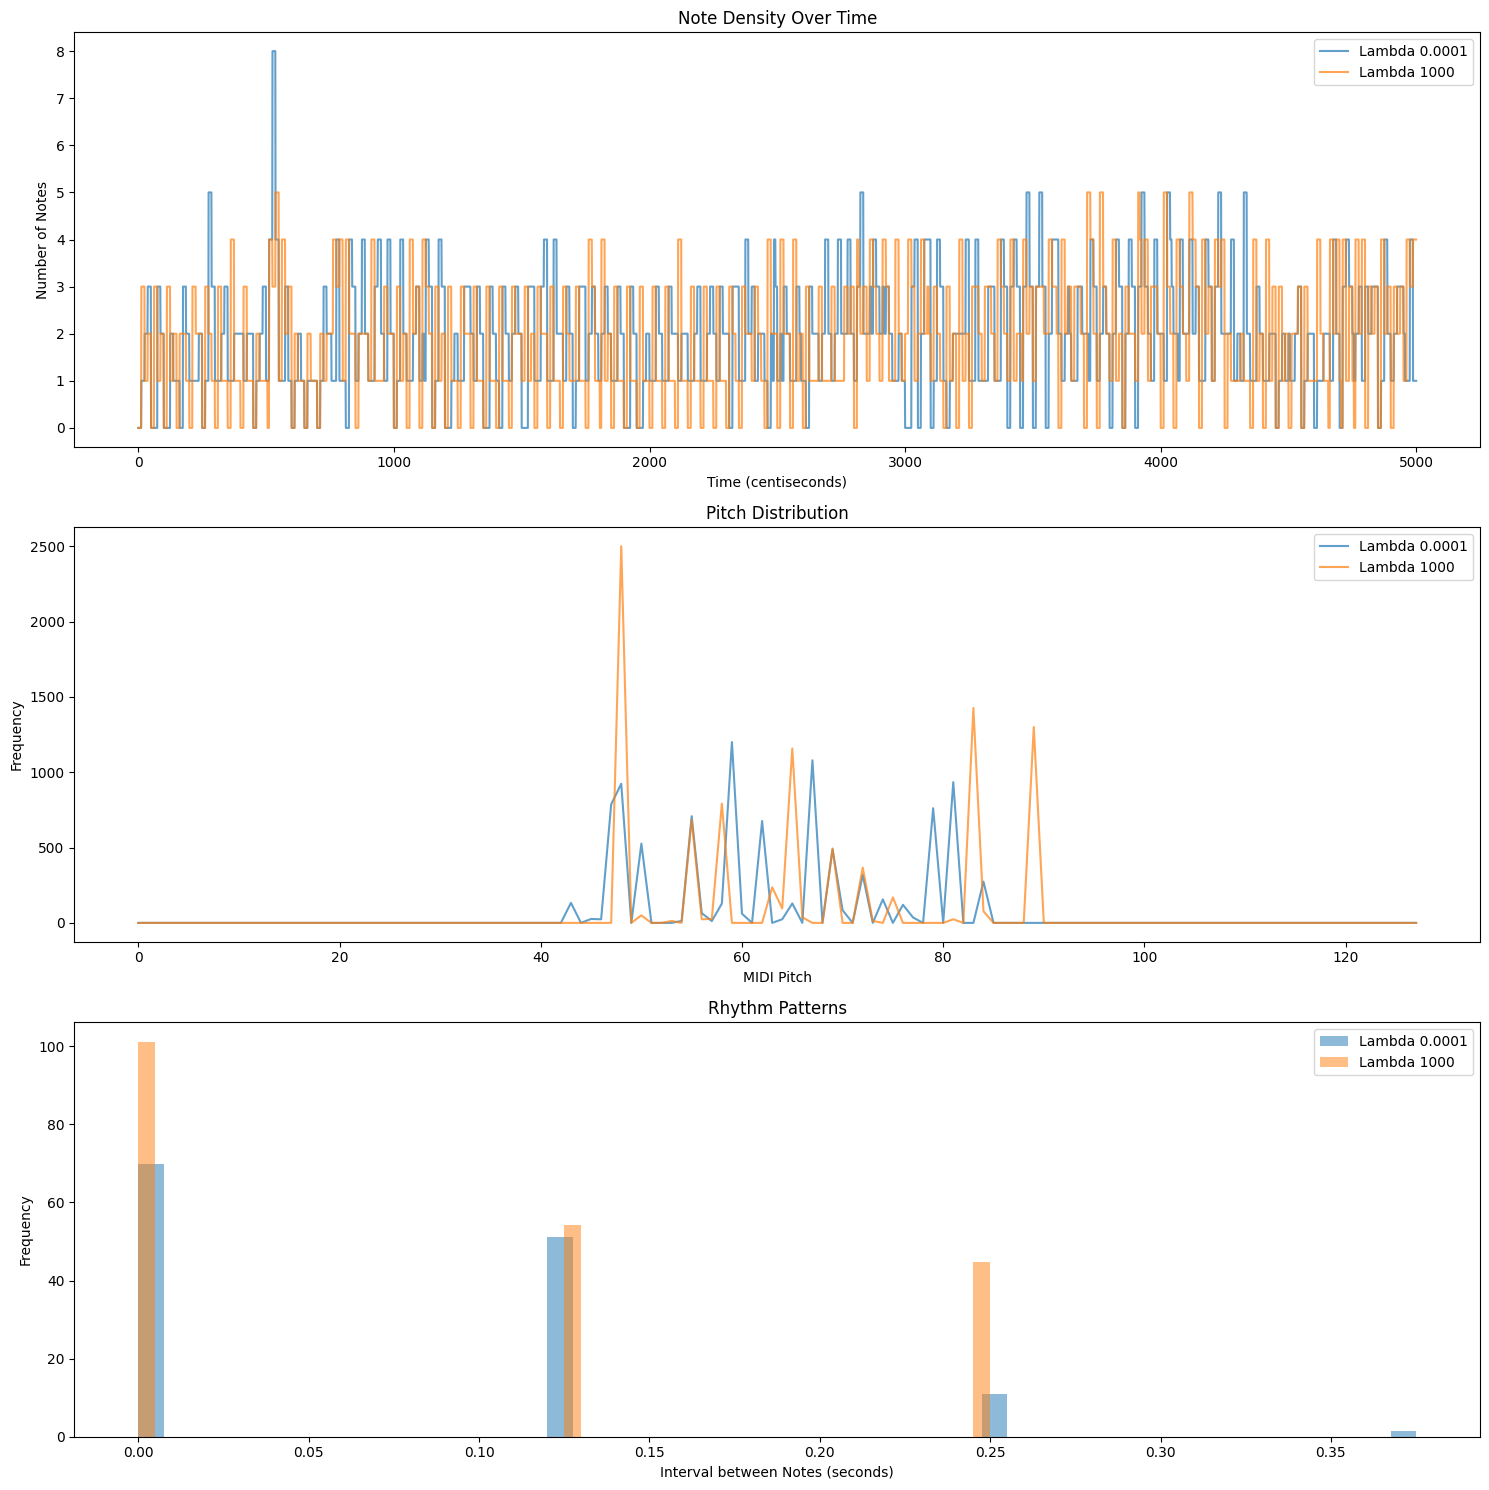

In [166]:
from pretty_midi import PrettyMIDI
import matplotlib.pyplot as plt
import numpy as np

# Analyze MIDI features
def analyze_midi(midi_file):
    pm = PrettyMIDI(midi_file)
    fs = 100  # Sampling rate for piano roll
    piano_roll = pm.get_piano_roll(fs=fs)

    note_density = np.sum(piano_roll > 0, axis=0)
    pitch_range = np.sum(piano_roll > 0, axis=1)

    onsets = []
    for instrument in pm.instruments:
        for note in instrument.notes:
            onsets.append(note.start)
    onsets = np.array(sorted(onsets))

    intervals = np.diff(onsets) if len(onsets) > 1 else np.array([])

    return {
        'note_density': note_density,
        'pitch_range': pitch_range,
        'duration': pm.get_end_time(),
        'intervals': intervals,
        'onsets': onsets
    }

# Plot analysis
def plot_analysis(features_1, features_2, labels):
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))

    # Note Density
    axs[0].plot(features_1['note_density'], label=labels['case1'], alpha=0.7)
    axs[0].plot(features_2['note_density'], label=labels['case2'], alpha=0.7)
    axs[0].set_title("Note Density Over Time")
    axs[0].set_xlabel("Time (centiseconds)")
    axs[0].set_ylabel("Number of Notes")
    axs[0].legend()

    # Pitch Distribution
    axs[1].plot(features_1['pitch_range'], label=labels['case1'], alpha=0.7)
    axs[1].plot(features_2['pitch_range'], label=labels['case2'], alpha=0.7)
    axs[1].set_title("Pitch Distribution")
    axs[1].set_xlabel("MIDI Pitch")
    axs[1].set_ylabel("Frequency")
    axs[1].legend()

    # Rhythm Patterns
    axs[2].hist(features_1['intervals'], bins=50, alpha=0.5, label=labels['case1'], density=True)
    axs[2].hist(features_2['intervals'], bins=50, alpha=0.5, label=labels['case2'], density=True)
    axs[2].set_title("Rhythm Patterns")
    axs[2].set_xlabel("Interval between Notes (seconds)")
    axs[2].set_ylabel("Frequency")
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# Compare results
def compare_results(file1, file2, label1, label2):
    features_1 = analyze_midi(file1)
    features_2 = analyze_midi(file2)

    labels = {'case1': label1, 'case2': label2}
    plot_analysis(features_1, features_2, labels)

# Example usage
compare_results('Results_Lambda_0.0001/100000.mid', 'Results_Lambda_1000/100000.mid',
                'Lambda 0.0001', 'Lambda 1000')


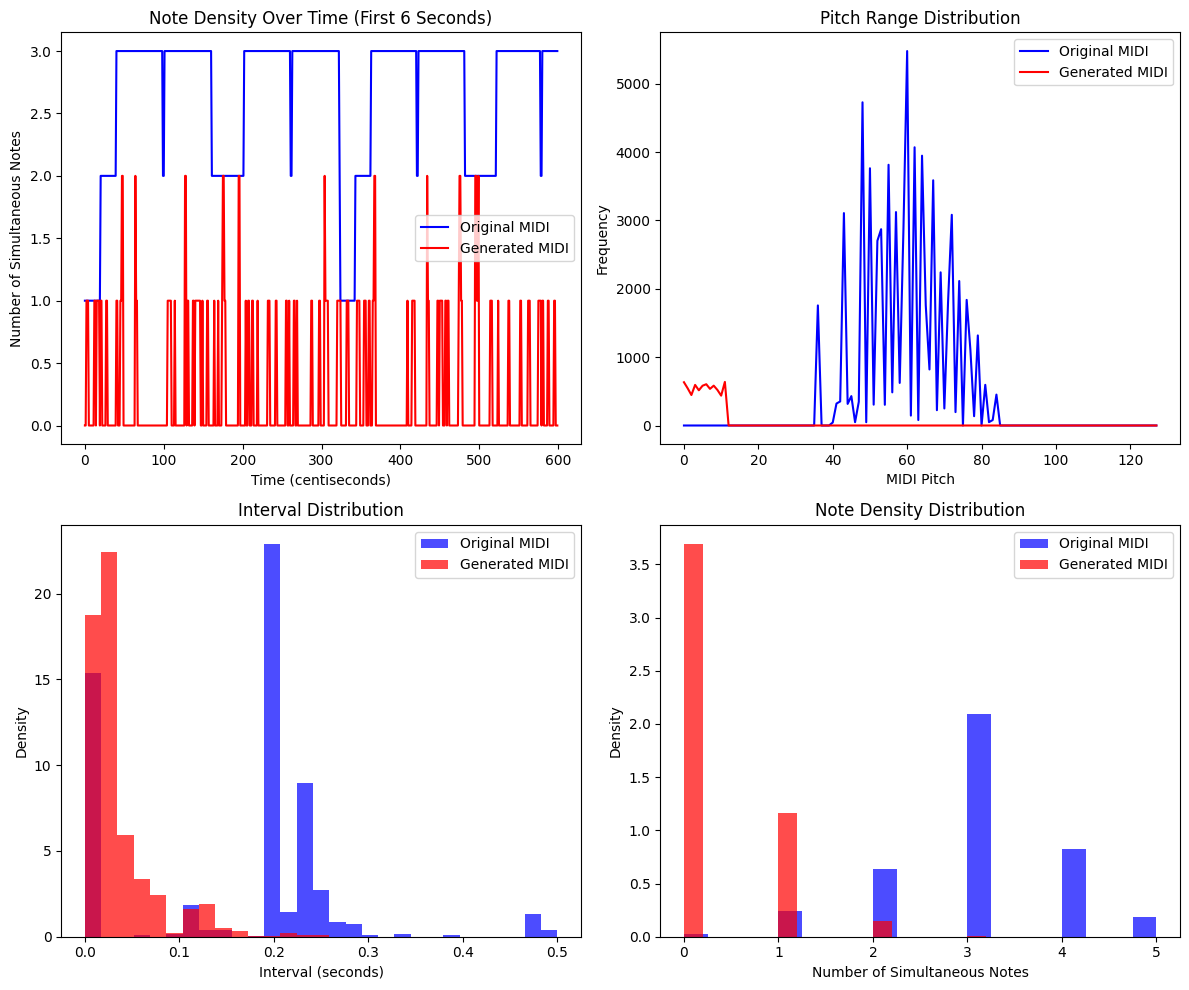

In [127]:
# Import libraries
import pretty_midi
import matplotlib.pyplot as plt
import numpy as np
import os

# Analyze MIDI file
def analyze_midi(midi_file):
    """
    Analyze MIDI file and extract musical features.
    """
    if not os.path.exists(midi_file):
        raise FileNotFoundError(f"MIDI file not found: {midi_file}")
    pm = pretty_midi.PrettyMIDI(midi_file)
    fs = 100  # Sampling frequency
    piano_roll = pm.get_piano_roll(fs=fs)

    note_density = np.sum(piano_roll > 0, axis=0)  # Number of notes active over time
    pitch_range = np.sum(piano_roll > 0, axis=1)  # Active pitches
    onsets = sorted([note.start for instrument in pm.instruments for note in instrument.notes])
    intervals = np.diff(onsets) if len(onsets) > 1 else np.array([])  # Time between note onsets

    return {
        'note_density': note_density,
        'pitch_range': pitch_range,
        'intervals': intervals,
        'duration': pm.get_end_time()
    }

# Plot comparison
def plot_comparison(features1, features2, labels, segment_length=600):
    """
    Plot comparison between two MIDI files based on extracted features.
    """
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    # Plot note density
    ax[0, 0].plot(features1['note_density'][:segment_length], label=labels[0], color='blue')
    ax[0, 0].plot(features2['note_density'][:segment_length], label=labels[1], color='red')
    ax[0, 0].set_title('Note Density Over Time (First 6 Seconds)')
    ax[0, 0].set_xlabel('Time (centiseconds)')
    ax[0, 0].set_ylabel('Number of Simultaneous Notes')
    ax[0, 0].legend()

    # Plot pitch range
    ax[0, 1].plot(features1['pitch_range'], label=labels[0], color='blue')
    ax[0, 1].plot(features2['pitch_range'], label=labels[1], color='red')
    ax[0, 1].set_title('Pitch Range Distribution')
    ax[0, 1].set_xlabel('MIDI Pitch')
    ax[0, 1].set_ylabel('Frequency')
    ax[0, 1].legend()

    # Plot intervals
    bins = np.linspace(0, 0.5, 30)  # Interval bins
    ax[1, 0].hist(features1['intervals'], bins=bins, alpha=0.7, label=labels[0], color='blue', density=True)
    ax[1, 0].hist(features2['intervals'], bins=bins, alpha=0.7, label=labels[1], color='red', density=True)
    ax[1, 0].set_title('Interval Distribution')
    ax[1, 0].set_xlabel('Interval (seconds)')
    ax[1, 0].set_ylabel('Density')
    ax[1, 0].legend()

    # Plot note density distribution
    ax[1, 1].hist(features1['note_density'], bins=20, alpha=0.7, label=labels[0], color='blue', density=True)
    ax[1, 1].hist(features2['note_density'], bins=20, alpha=0.7, label=labels[1], color='red', density=True)
    ax[1, 1].set_title('Note Density Distribution')
    ax[1, 1].set_xlabel('Number of Simultaneous Notes')
    ax[1, 1].set_ylabel('Density')
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Load and process data
def load_and_process_data(input_dir, num_timesteps):
    """
    Load MIDI files and convert them into chroma features.
    """
    midi_files = [f for f in os.listdir(input_dir) if f.endswith('.mid') or f.endswith('.midi')]
    processed_songs = {}
    for file in midi_files:
        midi_path = os.path.join(input_dir, file)
        if not os.path.exists(midi_path):
            print(f"File not found: {midi_path}")
            continue
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        piano_roll = midi_data.get_chroma()
        num_steps = (piano_roll.shape[1] // num_timesteps) * num_timesteps
        processed_songs[file] = piano_roll[:, :num_steps]
    return processed_songs

def generate_music(input_chromas, model, sess, output_dir, threshold=0.5):
    """
    Generate new music using the trained GAN model.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for song_name, chroma in input_chromas.items():
        # Reshape chroma to fit the model input size
        chroma_input = np.reshape(chroma, (-1, 48))
        print(f"Chroma input shape: {chroma_input.shape}")

        # Generate output from the model
        generated_output = sess.run(model, feed_dict={Z: chroma_input})
        print(f"Generated output shape: {generated_output.shape}")
        print(f"Expected chroma shape: {chroma.shape}")

        # Flatten the chroma for comparison
        expected_size = chroma.shape[0] * chroma.shape[1]
        
        # Adjust the output size
        if generated_output.size > expected_size:
            print("Trimming generated output to match expected size.")
            generated_output = generated_output.flatten()[:expected_size]
        elif generated_output.size < expected_size:
            print("Padding generated output to match expected size.")
            generated_output = np.pad(generated_output.flatten(), (0, expected_size - generated_output.size), mode='constant')
        
        # Reshape the output to match the chroma structure
        reshaped_output = np.reshape(generated_output, chroma.shape)
        print(f"Reshaped output shape: {reshaped_output.shape}")

        # Convert to MIDI
        midi_data = convert_to_midi(reshaped_output, threshold)
        output_path = os.path.join(output_dir, f"{song_name}_generated.mid")
        midi_data.write(output_path)

        # Verify file creation
        if not os.path.exists(output_path):
            raise FileNotFoundError(f"Failed to create MIDI file: {output_path}")
        else:
            print(f"MIDI file successfully created: {output_path}")



# Convert to MIDI
def convert_to_midi(piano_roll, threshold):
    """
    Convert piano roll back to MIDI format.
    """
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)
    time_step = 0.01  # Duration of each time step in seconds

    for time_idx, time_step_activation in enumerate(piano_roll.T):  # Iterate over time steps
        for note_index, note_activation in enumerate(time_step_activation):
            if note_activation >= threshold:
                note = pretty_midi.Note(
                    velocity=100, 
                    pitch=note_index, 
                    start=time_idx * time_step, 
                    end=(time_idx + 1) * time_step
                )
                instrument.notes.append(note)
    midi.instruments.append(instrument)
    return midi


# Paths
input_dir = "./Classical_Music_Midi/bach"
output_dir = "./Generated_Music"
timesteps = 32

# Analyze and process data
test_data = load_and_process_data(input_dir, timesteps)

# Example usage
original_midi = "./Classical_Music_Midi/bach/bach_846.mid"
generated_midi = os.path.join(output_dir, "bach_846.mid_generated.mid")

# Check if files exist
if not os.path.exists(original_midi):
    raise FileNotFoundError(f"Original MIDI file not found: {original_midi}")

if not os.path.exists(generated_midi):
    print(f"Generated MIDI file not found: {generated_midi}. Generating...")
    generate_music(test_data, G_sample, sess, output_dir)

# Analyze and compare
original_features = analyze_midi(original_midi)
generated_features = analyze_midi(generated_midi)

# Plot comparison
labels = ['Original MIDI', 'Generated MIDI']
plot_comparison(original_features, generated_features, labels)


##### Question 9 [20 points]

Please record a 2-5 minute video of yourself explaining questions 1 to 7.

If you are shy (or have a bad hairday) you can use filters to augment or cover your face. Please submit it as a public google drive url.

We have recorded a video explaining questions as requested. You can view it using the link below:

[Click here to view the explanation video](https://drive.google.com/file/d/1l7UHkrcV5zdX0ruRebtOAW2DnD1qxxT-/view?usp=sharing)